# Sparkify - Predicting User Churn

Sparkify is a fictional music streaming service similar to Spotify, with a free-tier supported by advertisements and a monthly subscription service. Predicting user churn enables them to target users who are considering leaving Sparkify and offering  special discounts or services to retain these users and maximize profit.

This code will use data about user interactions to create features that could be predictive of which users will churn, and then train and evaluate models for this prediction task.

## 1. PySpark Setup

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, desc, when, col, dense_rank
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import max as Fmax, min as Fmin, sum as Fsum, mean as Fmean, first as Ffirst

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['PYSPARK_PYTHON'] = 'python'

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

## 2. Load and Clean Dataset

In [3]:
#Read event data from mini file
path = "data/mini_sparkify_event_data.json"
sparkify_event_log = spark.read.json(path)

sparkify_event_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
#View first row of the data
sparkify_event_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
#Count number of rows
sparkify_event_log.count()

286500

In [6]:
#Check for any rows with a missing sessionId - these would likely be a data error within the Sparkify system
sparkify_event_log.filter(sparkify_event_log['sessionId'] == '').count()
#There are no rows which are missing a sessionId so no cleaning need to address these

0

In [7]:
#Check for any rows with a missing userId - these won't be useful to predict user churn
sparkify_event_log.filter(sparkify_event_log['userId'] == "").count()

8346

In [8]:
#Investigate which pages were visited by users without a UserId
sparkify_event_log.filter(sparkify_event_log['userId'] == "").select(sparkify_event_log['page']).distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



There are many rows without a userId. Looking at the events these relate to, they relate to Sparkify information pages such as Home, About and Help. It makes sense that these pages would be accessed by logged out or guest users so we can drop them from this dataset as they won't be useful for predicting churn.

In [9]:
user_event_log = sparkify_event_log.filter(sparkify_event_log['userId'] != "")
user_event_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
# Check for any other columns with null values
null_counts = {col:user_event_log.filter(user_event_log[col].isNull()).count() for col in user_event_log.columns}
null_counts 
#The only remaining null values are for artist, song, and length 
#these correspond to rows where the event is not listening to song, which seems sensible

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

In [11]:
#Drop columns that won't be useful to reduce memory requirements
user_event_log = user_event_log.drop('firstName','lastName','userAgent','artist','song')
user_event_log.head(5)

[Row(auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, status=200, ts=1538352117000, userId='30'),
 Row(auth='Logged In', gender='M', itemInSession=79, length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, status=200, ts=1538352180000, userId='9'),
 Row(auth='Logged In', gender='M', itemInSession=51, length=282.8273, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, status=200, ts=1538352394000, userId='30'),
 Row(auth='Logged In', gender='M', itemInSession=80, length=262.71302, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, status=200, ts=1538352416000, userId='9'),
 Row(auth='Logged In', gender='M', itemInSession=52, le

In [12]:
#Check for duplicate rows
print(user_event_log.count())
print(user_event_log.distinct().count())

278154
278154


The number of distinct rows in the event log equals the total number of rows, so there are no duplicate entries to deal with

## 3. Exploratory Data Analysis

In [13]:
#Count number of unique users
print('Unique users:', user_event_log.select("userId").dropDuplicates().count())

Unique users: 225


In [14]:
#Investigate page column
page_counts = user_event_log.groupby(user_event_log.page).count().orderBy('count', ascending=False)
page_counts.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



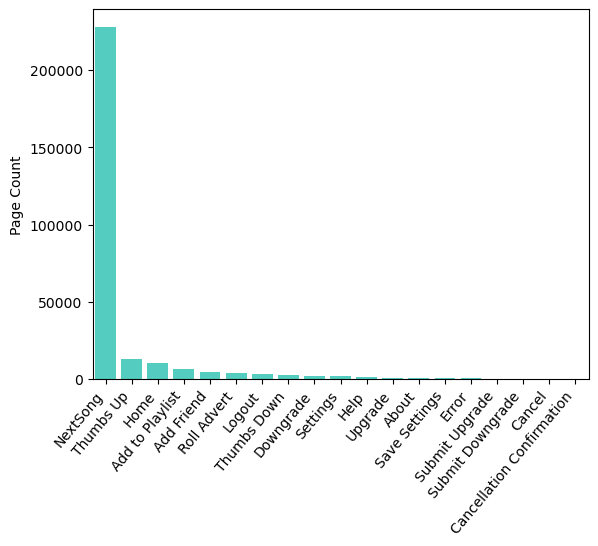

In [15]:
page_plot = sns.barplot(x='page', y='count', data=page_counts.toPandas(), color='turquoise')
page_plot.set_xlabel(None)
page_plot.set_ylabel("Page Count",fontsize=10)
plt.tick_params(labelsize=10)
plt.xticks(rotation=50, ha='right');

From this we can see that the majority of events correspond to playing songs, which makes sense for a music streaming service. Some of the other common events such as Thumbs Up, Add to Playlist or Roll Advert could be used to create predictive features.
The other key event here is the Cancel Confirmation page, which will be used to define user churn.

In [16]:
#Look at the range of values in other categorical columns
cat_cols = ['auth', 'gender', 'level', 'method', 'status']
for col in cat_cols:
    user_event_log.groupBy(col).count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



### Create user churn flag

In [17]:
#Create CHURN event flag using user-defined function
create_churn_event_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_event_log = user_event_log.withColumn("Churn_Event", create_churn_event_flag("page"))

user_event_log.head()

Row(auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, status=200, ts=1538352117000, userId='30', Churn_Event=0)

In [18]:
user_event_log.groupBy('Churn_Event').count().show()

+-----------+------+
|Churn_Event| count|
+-----------+------+
|          1|    52|
|          0|278102|
+-----------+------+



There were only 52 cancellation events out of the 278k rows - fortunately for Sparkify it looks like cancellation is a pretty rare event. Since we're interested in predicting which users will churn, we next need to flag all rows belonging to a churn user. We can do this by using a Window function to find the maximum value of the Churn_Event flag for each user and attach this to all their other log entries.

In [19]:
#create a window based on userId and sorted by event timestamp
user_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [20]:
user_event_log = user_event_log.withColumn("Churn_User", Fmax("Churn_Event").over(user_window))

In [21]:
#Check first few rows for a user known to have churned - now have Churn_User set for all of that user's rows
user_event_log.filter(user_event_log.userId == '18').head(3)

[Row(auth='Cancelled', gender='M', itemInSession=104, length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, status=200, ts=1538943990000, userId='18', Churn_Event=1, Churn_User=1),
 Row(auth='Logged In', gender='M', itemInSession=103, length=None, level='paid', location='Kansas City, MO-KS', method='PUT', page='Cancel', registration=1535623466000, sessionId=514, status=307, ts=1538943740000, userId='18', Churn_Event=0, Churn_User=1),
 Row(auth='Logged In', gender='M', itemInSession=102, length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Downgrade', registration=1535623466000, sessionId=514, status=200, ts=1538943739000, userId='18', Churn_Event=0, Churn_User=1)]

In [22]:
user_event_log.groupBy('Churn_User').count().show()
user_event_log.select('userId','Churn_User').distinct().groupBy('Churn_User').count().show()

+----------+------+
|Churn_User| count|
+----------+------+
|         1| 44864|
|         0|233290|
+----------+------+

+----------+-----+
|Churn_User|count|
+----------+-----+
|         1|   52|
|         0|  173|
+----------+-----+



From this we can see that nearly a quarter of the users in our dataset have churned, which would not be good for Sparkify's profits! We clearly need to find a way to identify these users before they churn and find strategies to prevent this. We can start by looking at the relationship between our Churn users and other users based on some of the other features in the event log.

In [23]:
#Select the latest row for each user 
#If they have churned this will be the cancellation page, otherwise whatever the user's last activity was
#There are a small number of users with two entries with identical timestamps, so added itemInSession to the ordering
#to ensure only 1 record is selected per user
user_time_window = Window.partitionBy('userId').orderBy(desc('ts'), desc('itemInSession'))

user_event_log = user_event_log.withColumn('Rank',dense_rank().over(user_time_window))

users_df = user_event_log.filter(user_event_log.Rank == 1).toPandas()
users_df.head(5)

,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,status,ts,userId,Churn_Event,Churn_User,Rank
0,Logged In,F,34,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,187,307,1542823952000,100010,0,0,1
1,Logged In,M,143,NaN,paid,"Chicago-Naperville-Elgin, IL-IN-WI",PUT,Thumbs Up,1536269906000,205,307,1542324354000,200002,0,0,1
2,Cancelled,M,10,NaN,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,200,1539318918000,125,1,1,1
3,Logged In,F,0,NaN,paid,"Vineland-Bridgeton, NJ",GET,Home,1532224335000,2426,200,1543590766000,124,0,0,1
4,Cancelled,M,176,NaN,paid,"Lexington-Fayette, KY",GET,Cancellation Confirmation,1538080987000,934,200,1539761972000,51,1,1,1


In [24]:
def plot_churn_counts(df, col):
    if col == 'Churn_User':
        plt = sns.countplot(x=col, data=df);
        plt.set_xlabel('User Churned', fontsize=15)
    else:
        plt = sns.countplot(x=col, data=df, hue='Churn_User');
        plt.set_xlabel(col.capitalize(), fontsize=15)
    plt.set_ylabel("Count of users", fontsize=15)
    plt.tick_params(labelsize=10)

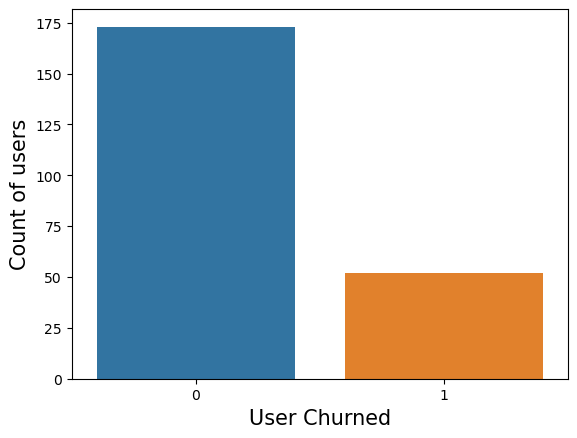

In [25]:
plot_churn_counts(users_df,'Churn_User')

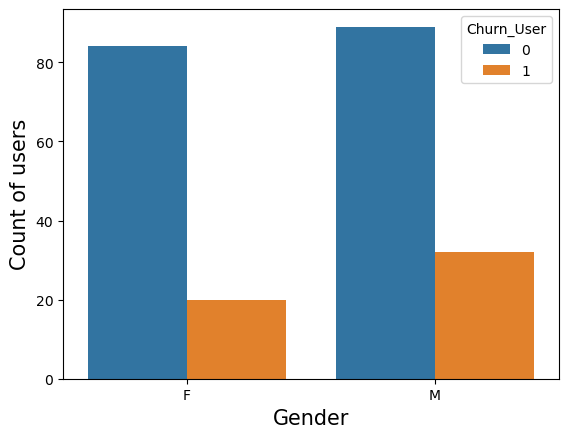

In [26]:
plot_churn_counts(users_df,'gender')

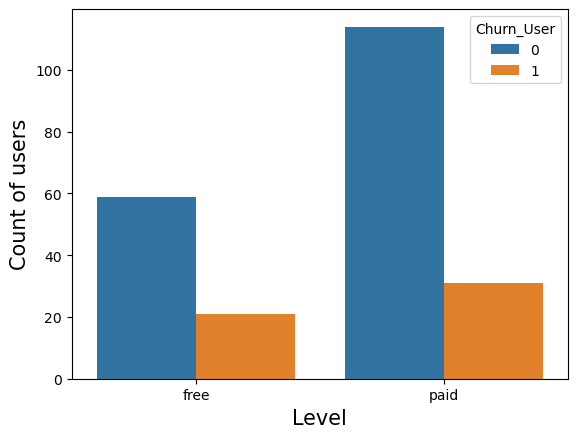

In [27]:
plot_churn_counts(users_df,'level')

## 4. Feature Engineering

Spark machine learning models require the input features to be in numeric form, so we'll focus on creating numeric rather than categorical factors. There are some categorical factors in the input data that can be easily converted to a binary numeric representation, so we will also consider these factors.

In [28]:
#Convert gender to binary categorical feature
user_event_log = user_event_log.withColumn("gender", when(user_event_log.gender == "M",0) \
      .when(user_event_log.gender == "F",1))

user_event_log.head()

Row(auth='Logged In', gender=1, itemInSession=34, length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, status=307, ts=1542823952000, userId='100010', Churn_Event=0, Churn_User=0, Rank=1)

The event log captures the user's subscription level (paid/free) at each page. Since we're looking to construct a user-level modelling dataset to predict which users will churn, it would be more useful to have a flag that indicates their most recent level and whether they have ever previously been in the paid tier.

In [29]:
#Map level to binary indicator
user_event_log = user_event_log.withColumn("level", when(user_event_log.level == "free",0) \
      .when(user_event_log.level == "paid",1))

In [30]:
#For each user, identify their most recent level in the event log using the Window function already used to identify churn
#Also create a flag to identify users who have ever been in the paid tier
user_current_level = user_event_log.select('userId',
                                           Ffirst('level',True).over(user_window).alias('current_level'),
                                           Fmax('level').over(user_window).alias('ever_paid')) \
                                    .distinct()

In [31]:
#create page-view counts per user, using the same approach as we used to create our churn flag
#ignore uninteresting pages such as About or Home
page_dict = {'friend': 'Add Friend', 'thumbs_up': 'Thumbs Up', 'thumbs_down': 'Thumbs Down',
             'upgrade': 'Submit Upgrade', 'downgrade': 'Submit Downgrade', 'song': 'NextSong', 
             'advert': 'Roll Advert', 'error': 'Error', 'playlist': 'Add to Playlist'
}
for key in page_dict.keys():
    udf_page = udf(lambda x: 1 if x == page_dict[key] else 0, IntegerType())
    user_event_log = user_event_log.withColumn('p_' + key, udf_page("page"))

#Check each page type has been set correctly
user_event_log.select('page',user_event_log.colRegex("`(p_)+?.+`")).distinct().show()


+--------------------+--------+-----------+-------------+---------+-----------+------+--------+-------+----------+
|                page|p_friend|p_thumbs_up|p_thumbs_down|p_upgrade|p_downgrade|p_song|p_advert|p_error|p_playlist|
+--------------------+--------+-----------+-------------+---------+-----------+------+--------+-------+----------+
|    Submit Downgrade|       0|          0|            0|        0|          1|     0|       0|      0|         0|
|          Add Friend|       1|          0|            0|        0|          0|     0|       0|      0|         0|
|     Add to Playlist|       0|          0|            0|        0|          0|     0|       0|      0|         1|
|       Save Settings|       0|          0|            0|        0|          0|     0|       0|      0|         0|
|         Roll Advert|       0|          0|            0|        0|          0|     0|       1|      0|         0|
|             Upgrade|       0|          0|            0|        0|          0| 

In [32]:
#Create count variables for each of these page views
#partition the dataframe based on the userId column
user_window = Window.partitionBy("userId")
#return the sum of values for each page type
for key in page_dict:
    user_event_log = user_event_log.withColumn('sum_' + key, Fsum('p_' + key).over(user_window))

#Check first few rows for unique users
user_page_counts = user_event_log.select('userId',user_event_log.colRegex("`(sum_)+?.+`")).distinct()
user_page_counts.show()

+------+----------+-------------+---------------+-----------+-------------+--------+----------+---------+------------+
|userId|sum_friend|sum_thumbs_up|sum_thumbs_down|sum_upgrade|sum_downgrade|sum_song|sum_advert|sum_error|sum_playlist|
+------+----------+-------------+---------------+-----------+-------------+--------+----------+---------+------------+
|100010|         4|           17|              5|          0|            0|     275|        52|        0|           7|
|200002|         4|           21|              6|          1|            0|     387|         7|        0|           8|
|   125|         0|            0|              0|          0|            0|       8|         1|        0|           0|
|   124|        74|          171|             41|          0|            0|    4079|         4|        6|         118|
|    51|        28|          100|             21|          0|            0|    2111|         0|        1|          52|
|     7|         1|            7|              1

Create session-aggregated features such as average length of session per user

In [33]:
songs_in_session = user_event_log.filter(user_event_log.page == "NextSong") \
                                .groupby([user_event_log.userId, user_event_log.sessionId]) \
                                .count() \
                                .orderBy(user_event_log.userId.cast("Int"))
songs_in_session.head(15)

[Row(userId='2', sessionId=1487, count=82),
 Row(userId='2', sessionId=1, count=359),
 Row(userId='2', sessionId=1928, count=80),
 Row(userId='2', sessionId=1342, count=17),
 Row(userId='2', sessionId=1639, count=162),
 Row(userId='2', sessionId=1560, count=5),
 Row(userId='2', sessionId=637, count=50),
 Row(userId='3', sessionId=374, count=39),
 Row(userId='3', sessionId=1226, count=115),
 Row(userId='3', sessionId=219, count=22),
 Row(userId='3', sessionId=1324, count=38),
 Row(userId='4', sessionId=760, count=5),
 Row(userId='4', sessionId=2318, count=12),
 Row(userId='4', sessionId=647, count=2),
 Row(userId='4', sessionId=2007, count=122)]

In [34]:
avg_songs_in_session = songs_in_session.groupBy('userId') \
                                        .agg(Fmean("count").alias("avg_songs_per_session")) \
                                        .orderBy(songs_in_session.userId.cast("Int"))
avg_songs_in_session.head(5)

[Row(userId='2', avg_songs_per_session=107.85714285714286),
 Row(userId='3', avg_songs_per_session=53.5),
 Row(userId='4', avg_songs_per_session=93.0909090909091),
 Row(userId='5', avg_songs_per_session=32.2),
 Row(userId='6', avg_songs_per_session=143.5909090909091)]

In [35]:
session_window = Window.partitionBy(["userId", "sessionId"]).orderBy(desc("ts")) \
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
session_timings = user_event_log.select('userId',
                                        'sessionId',
                                        Fmax('ts').over(session_window).alias('session_end'),
                                        Fmin('ts').over(session_window).alias('session_start')).distinct()
session_timings = session_timings.withColumn('session_duration_seconds', (session_timings['session_end'] - session_timings['session_start'])/1000)
session_timings.show(5)

+------+---------+-------------+-------------+------------------------+
|userId|sessionId|  session_end|session_start|session_duration_seconds|
+------+---------+-------------+-------------+------------------------+
|   101|      635|1539263366000|1539065365000|                198001.0|
|   110|     1776|1543573300000|1543568293000|                  5007.0|
|   120|      627|1539237966000|1539180886000|                 57080.0|
|   122|      691|1539888010000|1539886900000|                  1110.0|
|   140|      798|1539425132000|1539424555000|                   577.0|
+------+---------+-------------+-------------+------------------------+
only showing top 5 rows



In [36]:
avg_session_duration = session_timings.groupBy('userId') \
                                      .agg(Fmean('session_duration_seconds').alias("avg_session_duration_seconds")) \
                                        .orderBy(session_timings.userId.cast("Int"))
avg_session_duration.head(5)

[Row(userId='2', avg_session_duration_seconds=26701.0),
 Row(userId='3', avg_session_duration_seconds=14845.5),
 Row(userId='4', avg_session_duration_seconds=22760.31818181818),
 Row(userId='5', avg_session_duration_seconds=6371.5),
 Row(userId='6', avg_session_duration_seconds=32859.75)]

In [37]:
#Join together all of the newly engineered features to create a modelling dataset
join_df = user_current_level.join(avg_songs_in_session,'userId','outer') \
                  .join(avg_session_duration,'userId','outer') \
                  .join(user_page_counts,'userId','outer')



In [38]:
join_df.head()

Row(userId='100010', current_level=0, ever_paid=0, avg_songs_per_session=39.285714285714285, avg_session_duration_seconds=9269.0, sum_friend=4, sum_thumbs_up=17, sum_thumbs_down=5, sum_upgrade=0, sum_downgrade=0, sum_song=275, sum_advert=52, sum_error=0, sum_playlist=7)

## 5. Modelling